# Modelling and Evaluation

## Objectives

- Answer business objective 2:
    - The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew.

## Inputs

- inputs/malaria_dataset/cell_images/train
- inputs/malaria_dataset/cell_images/test
- inputs/malaria_dataset/cell_images/validation
- image shape pickle file

## Outputs

- Machine learning model creation and training
- Save model
- Learning curve plot for model performance
- Model evaluation on pickle file
- Prediction on the random image file

## Additional Comments

- None

---

# Get directories
## Change working directory

In [1]:
import os

current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")
current_dir = os.getcwd()
current_dir

You set a new current directory


'/workspaces/powdery_mildew_detection'

## Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

## Set input directories
Set train, test, and validation paths.

In [ ]:
my_data_dir = 'inputs/mildew_detection/cherry_leaves'
train_path = my_data_dir + '/train'
validation_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [ ]:
version = 'v3'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
  print('Old version is already available create a new version.')
  pass
else:
  os.makedirs(name=file_path)

## Set label names

In [ ]:
labels = os.listdir(train_path)
print('Label for the images are',labels)

## Set image shape

In [ ]:
## Import saved image shape pickle file
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

## Image Augmentation
Create new images with small tweaks, such as a rotaton or zoom, to emulate more data.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmented_image_data = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.10, 
                                   height_shift_range=0.10,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   rescale=1./255
                              )

In [ ]:
batch_size = 20 # Set batch size

train_set = augmented_image_data.flow_from_directory(train_path,
                                              target_size=image_shape[:2],
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True
                                              )

train_set.class_indices

validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                          target_size=image_shape[:2],
                                                          color_mode='rgb',
                                                          batch_size=batch_size,
                                                          class_mode='categorical',
                                                          shuffle=False
                                                          )

validation_set.class_indices

test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                    target_size=image_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False
                                                    )

test_set.class_indices

### Plot augmented images

In [ ]:
print("Train set")
for _ in range(3):
    img, label = train_set.next()
    print(img.shape) 
    plt.imshow(img[0])
    plt.show()

print("Validation set")
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()
    
print("Test set")
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

## Save class_indices

In [10]:
joblib.dump(value=train_set.class_indices ,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v3/class_indices.pkl']

# Model Creation

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

## Model
We will create a model with convolution and pooling, flatten, dense, dropout layers.
The activation function is softmax, to give us a bnary output representing the healthy and powdery mildew categories.

In [12]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))

    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

### Model Summary

In [13]:
create_tf_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0

2023-12-30 00:25:32.329230: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Early Stopping

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=3)

## Fit model for Model Training

In [15]:
model = create_tf_model()
model.fit(train_set,
          epochs=10,
          steps_per_epoch = len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

2023-12-30 00:25:39.365329: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


InvalidArgumentError:  logits and labels must have the same first dimension, got logits shape [20,2] and labels shape [40]
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at tmp/ipykernel_20276/1988692170.py:2) ]] [Op:__inference_train_function_975]

Function call stack:
train_function


## Save Model

In [16]:
model.save(f"{file_path}/powdery_mildew_detector_model.h5")

# Model Performance
## Performance Curve

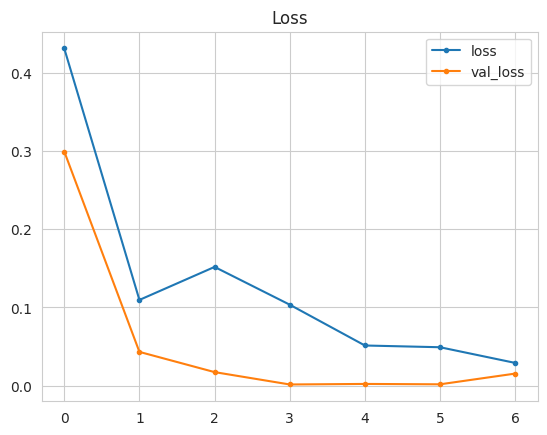

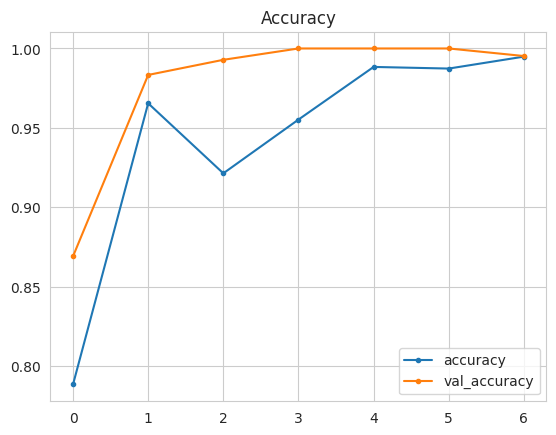

In [17]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

## Model Evaluation

In [ ]:
from keras.models import load_model
model = load_model(f"{file_path}/powdery_mildew_detector_model.h5")
evaluation = model.evaluate(test_set)

Save evaluation pickle

In [ ]:
joblib.dump(value=evaluation ,filename=f"{file_path}/evaluation.pkl")

## Live Prediction
Load random image as PIL and convert image to array

In [ ]:
from tensorflow.keras.preprocessing import image

pointer = 12
label = labels[1] # select healthy [0] or powdery mildew [1]
labels = os.listdir(validation_path)
print(label)

pil_image = image.load_img(validation_path + '/'+ label + '/'+ os.listdir(validation_path+'/'+ label)[pointer],
                          target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

In [ ]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)
print(my_image.shape)
print(my_image)

Predict healthy or powdery mildew

In [ ]:
pred = model.predict(my_image)
pred_class = np.argmax(pred, axis=-1)

print(pred)

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_class[0]]
print(pred_class)


In [73]:
pred = model.predict(my_image)
np.argmax(pred[0])


0

# Push files to repo
Push new files to repo to save the models and evaluations

In [ ]:
!git add .

In [ ]:
!git commit -m "Add model v3 results, save model"

In [ ]:
!git push